In [214]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tools
import pandas as pd
import torch
import model
from sklearn.metrics import adjusted_rand_score, jaccard_score, fowlkes_mallows_score, silhouette_score

FILE_PATH = "./data/"
MODEL_PATH = './model/'

In [215]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=40, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
targets = dataset.target
len(documents)

11314

In [444]:
num = np.zeros((20,1))
for i in range(len(targets)):
    num[targets[i]]+=1
num

array([[468.],
       [569.],
       [567.],
       [578.],
       [556.],
       [590.],
       [577.],
       [562.],
       [583.],
       [573.],
       [584.],
       [582.],
       [574.],
       [578.],
       [577.],
       [590.],
       [532.],
       [547.],
       [452.],
       [361.]])

In [216]:
news_df = pd.DataFrame({'document':documents, 'target':targets})
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())
news_df['clean_doc']

/var/folders/nt/tsy7wf3x21lbzqxz5p0bl6nw0000gn/T/ipykernel_53940/3716533461.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")


0        i have the following    rpm singles for sale  ...
1         i have to beg to differ on this point  as the...
2         was that your argument   well  you didn t mak...
3        i want to compile xdvi and later perhaps emacs...
4        i m looking to buy a used motorcycle helmet   ...
                               ...                        
11309    adam benson mt  pearl  nf adamb garfield cs mu...
11310                                                     
11311         you do mean disks  don t you  not tapes  ...
11312     dos         cannot read the ntfs file system ...
11313    trade your old pc for my new modem  modem come...
Name: clean_doc, Length: 11314, dtype: object

In [217]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

In [218]:
def load_data_agnews(sentence, batch_size, max_window_size, num_noise_words):
    vocab = tools.Vocab(sentence)
    subsampled, counter = tools.subsample(sentence, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = tools.get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = tools.get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class AGNewsDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = AGNewsDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=tools.batchify)
    return data_iter, vocab

In [219]:
corpus = news_df['clean_doc'].to_list()
sentence = []
targets = []
for i in range(len(corpus)):
    if len(corpus[i]) !=0:
        sentence.append(corpus[i])
        targets.append(dataset.target[i])
text = tools.tokenize(sentence)
data_iter, vocab = load_data_agnews(text, 512, 5, 5)

In [220]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english',max_df=0.5, smooth_idf=True)

X = vectorizer.fit_transform(sentence)
X.shape

(11000, 72585)

In [388]:
def eval(targets, predict, features):
    print(adjusted_rand_score(targets,predict))
    print(jaccard_score(targets,predict, average="micro"))
    print(fowlkes_mallows_score(targets,predict))
    print(silhouette_score(features, predict))

In [372]:
from sklearn.cluster import KMeans
kmeans = KMeans(20,random_state=0,n_init='auto').fit(X)
predict = kmeans.labels_
eval(targets, predict, X)

0.10354545454545455
0.07974787845128604
0.05459949187479028
0.16385841983155502
0.005125431359903316


In [222]:
X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [306]:
from sklearn.decomposition import PCA
pca = PCA(100)
features = pca.fit_transform(np.asarray(X.todense()))

ValueError: 'n_components' should be inferior to 4 for the barnes_hut algorithm as it relies on quad-tree or oct-tree.

In [303]:
kmeans = KMeans(20,random_state=0,n_init='auto').fit(features)
predict = kmeans.labels_
eval(targets, predict, X)

0.13063636363636363
0.2624456916031159
0.06988279920245101
0.30542408045703
0.004781699363117766


In [327]:
from sklearn.manifold import TSNE
tsne = TSNE(2)
draw_feature = tsne.fit_transform(np.asarray(X.todense()))

Text(0.5, 1.0, 'KMeans')

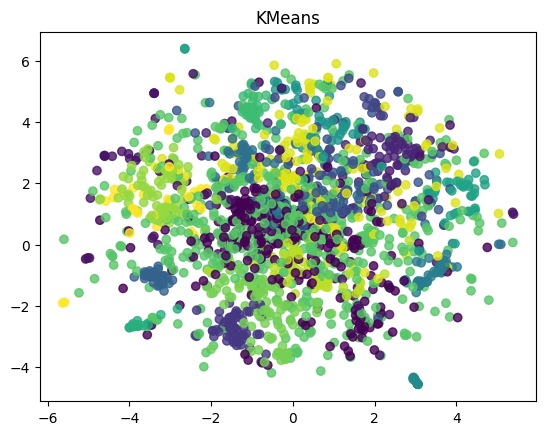

In [373]:
plt.scatter(draw_feature[:2000,0], draw_feature[:2000,1],c=predict[:2000],alpha=0.8)
plt.title('KMeans')

In [370]:
from sklearn.decomposition import TruncatedSVD

svd_model = TruncatedSVD(n_components=20)
new_X = svd_model.fit_transform(X)
predict = np.argmax(new_X, axis=1)
eval(targets, predict, new_X)

0.04554545454545455
0.011033575685007627
0.02330340946090516
0.17413466406499387
0.059920960693401144


Text(0.5, 1.0, 'LDA')

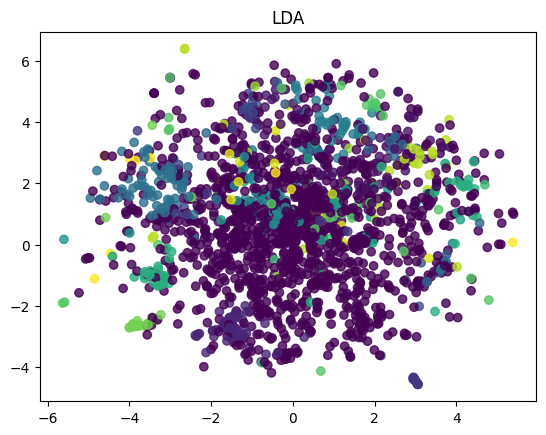

In [371]:
plt.scatter(draw_feature[:2000,0], draw_feature[:2000,1],c=predict[:2000],alpha=0.8)
plt.title('LDA')

In [317]:
embbed_size = 100
lr, num_epochs = 0.005, 9
net = model.word2vec_net(vocab, embbed_size)
epoch_loss = model.train(net, data_iter, vocab, lr, num_epochs,init='none')
state = {'net': net.state_dict(), 'epoch': num_epochs}
torch.save(state, MODEL_PATH + "wor2vec")

0.5376787285301343
0.48971583818760084
0.46560126674140306
0.4496696189788779
0.43804355665735484
0.4379409898885882
0.42215221474157943
0.4105314504834316
0.4016707773354328
0.39468726628967893
0.3890510954931192
0.38899590340360124
0.3783869016693604
0.37007143514389307
0.36345724618485
0.3581159375816642
0.3537376671137635
0.35369704564557797
0.34648577613655346
0.34060682423345706
0.3358058540443254
0.33184587808088867
0.3285013669368664
0.32846957280250005
0.3232664146373164
0.3189971198693214
0.3154090337635028
0.3124169202797484
0.30986575509862735
0.30984157385728645
0.30590660109358536
0.30265005403053225
0.29988779812526395
0.2975347397657855
0.29553096827281844
0.29551104706028936
0.29242915790249496
0.2898210039676038
0.28762482014706525
0.2857686125564359
0.2841593633703655
0.2841437606305416
0.28165226415783756
0.2795591828111317
0.2777579060937556
0.27623142602049566
0.27491573251746065
0.27490336540233856
0.27284114716055624
0.2710858575963458
0.26961069469098764
0.2683

array([1.        , 1.16666667, 1.33333333, 1.5       , 1.66666667,
       1.83333333, 2.        , 2.16666667, 2.33333333, 2.5       ,
       2.66666667, 2.83333333, 3.        , 3.16666667, 3.33333333,
       3.5       , 3.66666667, 3.83333333, 4.        , 4.16666667,
       4.33333333, 4.5       , 4.66666667, 4.83333333, 5.        ,
       5.16666667, 5.33333333, 5.5       , 5.66666667, 5.83333333,
       6.        , 6.16666667, 6.33333333, 6.5       , 6.66666667,
       6.83333333, 7.        , 7.16666667, 7.33333333, 7.5       ,
       7.66666667, 7.83333333, 8.        , 8.16666667, 8.33333333,
       8.5       , 8.66666667, 8.83333333, 9.        , 9.16666667,
       9.33333333, 9.5       , 9.66666667, 9.83333333])

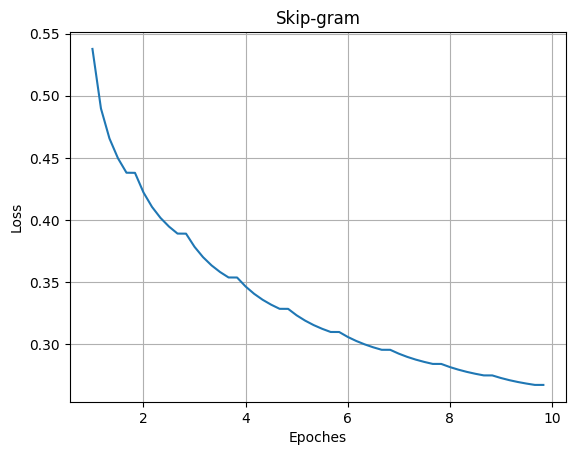

In [325]:
idx = list(range(len(epoch_loss[1])))
idx = np.array(idx)/6 +1 
plt.plot(idx,epoch_loss[1])
plt.grid()
plt.title("Skip-gram")
plt.ylabel("Loss")
plt.xlabel("Epoches")

In [328]:
# net.load_state_dict(torch.load(MODEL_PATH + "wor2vec")['net'])
W = net[0].weight.data
print(W.size())
features = []
for i in range(len(text)):
    x = W[vocab[text[i]]]
    features.append(torch.mean(x,dim=0).numpy())
features = np.array(features)
features.shape
np.save("word2vec.npy", features)

torch.Size([74341, 100])


In [368]:
features = np.load("word2vec.npy")
kmeans = KMeans(20,random_state=0,n_init='auto').fit(features)
predict = kmeans.labels_
eval(targets,predict,features)

0.09336363636363636
0.28082858229374197
0.048967720402422164
0.32459349572763596
0.02771894


In [366]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.9,min_samples=10).fit(features)
predict = dbscan.labels_
eval(targets,predict,features)

0.019363636363636364
0.007059343508152128
0.009776472208197549
0.17492305996211865
-0.008681832


In [357]:
from scipy.cluster.hierarchy import linkage, fcluster
Z = linkage(features, method="ward", metric="euclidean")
predict = fcluster(Z, t=20, criterion="maxclust")
eval(targets,predict,features)

0.0740909090909091
0.2662524954985923
0.03847061600188813
0.31849313441872795
0.014336122


In [ ]:
Hierarchical

Text(0.5, 1.0, 'KMeans')

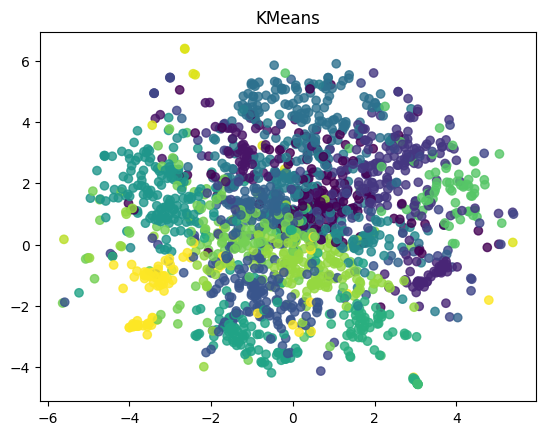

In [369]:
plt.scatter(draw_feature[:2000,0], draw_feature[:2000,1],c=predict[:2000],alpha=0.8)
plt.title('KMeans')

In [374]:
embbed_size = 100
lr, num_epochs = 0.005, 9
net = model.word2vec_net(vocab, embbed_size)
epoch_loss = model.train(net, data_iter, vocab, lr, num_epochs,init='glove')
state = {'net': net.state_dict(), 'epoch': num_epochs}
torch.save(state, MODEL_PATH + "wor2vec_glove")

/Users/kingsleycheng/Documents/github/UCAS/TextDataMining/Homework/model.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m.weight.data[i] = torch.tensor(glove100[[char]][0])


1.871069080319223
1.267371491952376
1.0137760400014655
0.8746390304694777
0.7860051199487926
0.7852454900360003
0.7110179710226777
0.6580785758810447
0.618341354416116
0.5875004792092073
0.5628257403110597
0.5625949329688632
0.5368741645848834
0.5159490402966536
0.49871391179165075
0.48425238517688474
0.4719101772201872
0.4717919635204341
0.45784312055976256
0.4460330223386284
0.4359253785153286
0.4271691876479609
0.4195628606816749
0.41948732897176616
0.4104344916176922
0.40260405564534774
0.3958136034949865
0.3898467532176227
0.38456832949436814
0.38451859418145207
0.37808944575761
0.3724720904803828
0.367511300310965
0.36310333817333906
0.35916881147728874
0.3591303127162703
0.3542507818835233
0.3499567769680258
0.34616879001099754
0.3428025921518193
0.3397602241052581
0.3397310267424048
0.3358964421182629
0.332508760212423
0.329503226783829
0.3268117954185959
0.32437947562720315
0.32435640376740027
0.3212368248617842
0.31848841831140634
0.3160549510893484
0.3138585320680396
0.31186

Text(0.5, 0, 'Epoches')

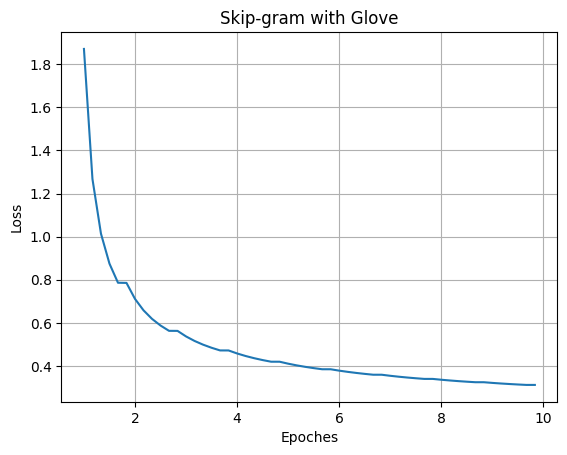

In [375]:
idx = list(range(len(epoch_loss[1])))
idx = np.array(idx)/6 +1 
plt.plot(idx,epoch_loss[1])
plt.grid()
plt.title("Skip-gram with Glove")
plt.ylabel("Loss")
plt.xlabel("Epoches")

In [376]:
# net.load_state_dict(torch.load(MODEL_PATH + "wor2vec")['net'])
W = net[0].weight.data
features = []
for i in range(len(text)):
    x = W[vocab[text[i]]]
    features.append(torch.mean(x,dim=0).numpy())
features = np.array(features)
print(features.shape)
np.save("word2vec_glove.npy", features)

(11000, 100)


In [377]:
features = np.load("word2vec_glove.npy")
kmeans = KMeans(20,random_state=0,n_init='auto').fit(features)
predict = kmeans.labels_
eval(targets,predict,features)

0.022727272727272728
0.25664370076699866
0.011494252873563218
0.30631253600324904
0.02583398


In [399]:
dbscan = DBSCAN(eps=0.9,min_samples=10).fit(features)
predict = dbscan.labels_
eval(targets,predict,features)

0.006509628579559434
0.008203107098666422
0.18111958126032895
-0.03905582


In [401]:
from scipy.cluster.hierarchy import linkage, fcluster
Z = linkage(features, method="ward", metric="euclidean")
predict = fcluster(Z, t=20, criterion="maxclust")
eval(targets,predict,features)

0.241276188286289
0.024160886364694382
0.2979318001298619
0.009643149


Text(0.5, 1.0, 'Hierarchical')

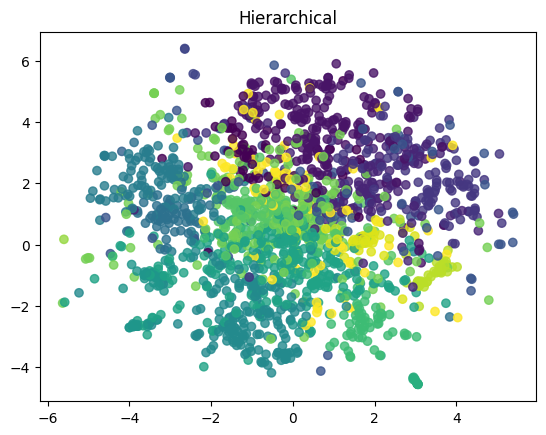

In [402]:
plt.scatter(draw_feature[:2000,0], draw_feature[:2000,1],c=predict[:2000],alpha=0.8)
plt.title('Hierarchical')

In [403]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [165]:
sentence_embeddings = model.encode(sentence)

In [435]:
# pca = PCA(100)
# features = pca.fit_transform(sentence_embeddings)
features = sentence_embeddings

In [440]:
kmeans = KMeans(20,random_state=0,n_init='auto').fit(features)
predict = kmeans.labels_
eval(targets,predict,features)

0.16764007977641274
0.032912343302502464
0.210452156532931
0.01699236


In [428]:
Z = linkage(features, method="ward", metric="euclidean")
predict = fcluster(Z, t=20, criterion="maxclust")
eval(targets,predict,features)

0.1413963265291468
0.013031265828613529
0.1894372348894458
0.0026187033


Text(0.5, 1.0, 'KMeans')

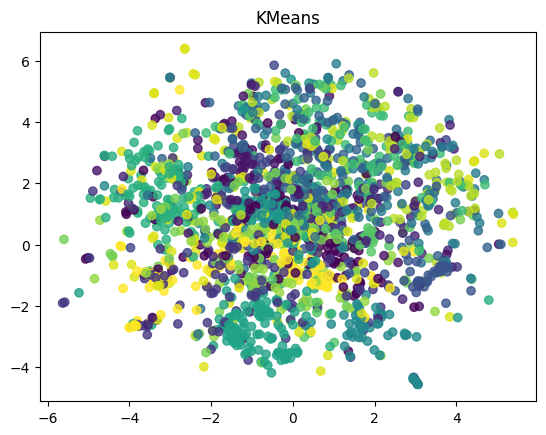

In [442]:
plt.scatter(draw_feature[:2000,0], draw_feature[:2000,1],c=predict[:2000],alpha=0.8)
plt.title('KMeans')